In [1]:
import os
import subprocess
import shutil
import pandas as pd
import numpy as np
import lumpyrem as lr
from lumpyrem import run
import matplotlib.pyplot as plt
import pyemu
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries
olproc_input_pth = os.path.join('..', 'data', 'olproc_input') # Measured heads
data_dir = os.path.join('..', 'data', 'raw_data', 'precipitation_evapotranspiration') # Raw climate data
ws = os.path.join('..', 'temp_lr_calib') # Workspace

In [3]:
if os.path.exists(ws):
    shutil.rmtree(ws)
os.mkdir(ws)

In [87]:
head = pyemu.utils.smp_utils.smp_to_dataframe(os.path.join(olproc_input_pth, 'obs-head-all.ssf'))

In [88]:
head.name.unique()

array(['b10-1', 'b14-1', 'b15-1', 'b16-1', 'b2-1', 'b22-1', 'b26', 'b29',
       'b34', 'b35', 'b36', 'b37', 'b4', 'b8-2', 'b9-2', 'kb1-1', 'kb4-3',
       'ni1403-2', 'ni1404-1', 'ni1405-1', 'ni1407-2', 'ni1408-1',
       'ni1409-1', 'ni1410-1', 'ni1412-1', 'ni15-o1', 'ni15-o44',
       'ni15-o46', 'ni15-o47', 'ni15-o48', 'ni1501-3', 'ni1502-2',
       'ni1504-2', 'ni1505-2', 'ni1506-1', 'ni1507-2', 'ni1601-3',
       'ni1602-1', 'ni1603-1', 'ni1605-1', 'ni1606-1', 'ni1607-2',
       'ni1608-1', 'ni1609-2', 'ni1610-2', 'ni1611-1', 'ni1612-1',
       'ni1613-1', 'ni1701-1', 'ni1702-1', 'ni1703-1', 'ni1704-1',
       'ni1705-1', 'ni1706-1', 'ni1707-1', 'ni1708-1', 'ni1709-1',
       'ni1711-1', 'ni1712-1', 'ni1801-1', 'ni1802-1', 'ni1803-1',
       'ni1804-1'], dtype=object)

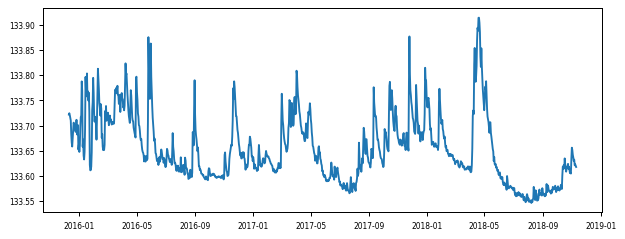

In [89]:
# select the well to calibrate against
head = head.loc[head.name == 'ni15-o48'].reset_index(drop=True)
plt.figure(figsize=(8,3), dpi=90)
plt.plot(head.datetime, head.value)

In [90]:
head.min()

datetime    2015-12-10 12:00:00
name                   ni15-o48
value                   133.546
dtype: object

In [91]:
# Save to OLPROC path
pyemu.utils.smp_utils.dataframe_to_smp(
    head,
    os.path.join(ws, 'obs-head-lrcalib.ssf'),
    name_col='name',
    datetime_col='datetime',
    value_col='value',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

In [92]:
# rainfall
rf_df = pd.read_csv(os.path.join(data_dir, 'smhi-opendata_5_103100_20210413_212824.csv'), delimiter=';', header=6)
rf_df = rf_df[['Representativt dygn', 'Nederbördsmängd']]
rf_df.rename(columns={'Representativt dygn': 'datetime', 'Nederbördsmängd': 'precipitation'}, inplace=True)
rf_df['datetime'] = pd.to_datetime(rf_df['datetime'])

In [93]:
#greater than the start date and smaller than the end date
start_date = pd.Timestamp(head['datetime'][0:].values[0]) #Must be the day before the first day
end_date = pd.Timestamp(head['datetime'][-1:].values[0])
mask = (rf_df['datetime'] > start_date) & (rf_df['datetime'] <= end_date)
rf_df = rf_df.loc[mask].reset_index(drop=True)

In [94]:
rf_df['precipitation'] = rf_df['precipitation'] / 1000
rf_df['simulation_day'] = rf_df.index + 1
rf_df = rf_df[['simulation_day','precipitation']]
rf_df.to_csv(os.path.join(ws, 'rainfall.dat'), sep=' ', header=False, index=False)

In [95]:
start_date

Timestamp('2015-12-10 12:00:00')

In [96]:
# evapotranspiration
xl_file = pd.ExcelFile(os.path.join(data_dir, 'smhi-s-hype-64808.xls'))
ev_df = xl_file.parse('Månadsvärden')
ev_df.rename(columns={'Unnamed: 0': 'datetime', 'Lokal\nevapotranspiration\n[mm]': 'evapot'}, inplace=True)
ev_df = ev_df[['datetime', 'evapot']]
ev_df = ev_df[:-2]
ev_df['datetime'] = pd.to_datetime(ev_df['datetime'], format='%Y-%m')
ev_df['days_in_month'] = [pd.Period(str(i)).days_in_month for i in ev_df['datetime']]
ev_df['mean_daily_evapot'] = ev_df['evapot'] / ev_df['days_in_month']
ev_df['mean_daily_evapot'] = ev_df['mean_daily_evapot'] / 1000
mask = (ev_df['datetime'] > '2015-11-01') & (ev_df['datetime'] <= end_date) #Must be one month before the first
ev_df = ev_df.loc[mask].reset_index(drop=True)
ev_df.index = ev_df['datetime']

In [97]:
start_date = ev_df.index.min() - pd.DateOffset(day=1)
end_date = ev_df.index.max() + pd.DateOffset(day=31)

In [98]:
dates = pd.date_range(start_date, end_date, freq='D')
dates.name = 'date'
ev_df = ev_df.reindex(dates, method='ffill')

In [99]:
ev_df = ev_df.iloc[10:-21]
ev_df['simulation_day'] = [i+1 for i in range(len(ev_df))]
ev_df = ev_df[['simulation_day','mean_daily_evapot']].reset_index(drop=True)
ev_df.to_csv(os.path.join(ws, 'evapot.dat'), sep=' ', header=False, index=False)

In [172]:
# initiate the model and write the in files. What about rbuf & mbuf?
# landuse model for recharge, evap
lr_model = lr.lumprem.Model(
    model_name = 'calib_tmp',
    workspace = ws,
    ### Earth properties row 1
    maxvol = 0.54, # -- PEST adjustable parameter
    irrigvolfrac = 0.0,
    ### Earth properties row 3
    ks = 153.0, # -- PEST adjustable parameter
    M = 0.17, # -- PEST adjustable parameter
    L = 0.5, # -- PEST adjustable parameter
    ### Volume to elevation
    factor1 = 1.06, # -- PEST adjustable parameter
    factor2 = 0.83, # -- PEST adjustable parameter
    power = 0.72, # -- PEST adjustable parameter
    offset = 133.1, # Measured head in nearby well
    ### Initial conditions
    vol = 0.268, # -- PEST adjustable parameter
    ### Data filenames
    vegfile=(2.207, 2.07), #cropfac_all, gamma_all -- PEST adjustable parameter
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [173]:
len(head) / 152

7.0

In [174]:
str(end_date)[:10]

'2018-11-30'

In [175]:
#lr.lumprem.Model??

In [176]:
lr_model.write_model(
    start_date = '10/12/2015',
    end_date = '09/11/2018',
    noutdays = 152, # 152 days = every seven days between start and end_date
    nstep = 200,
    mxiter = 10000,
    tol = 1e-9,
)
lr_model.run_model(version=2)
results = lr_model.get_results()

LUMPREM model input file written to: 
..\temp_lr_calib\lr_calib_tmp.in
PEST template file written to: 
..\temp_lr_calib\lr_calib_tmp.tpl

 Enter name of LUMPREM input file:  Enter name for LUMPREM tabular output file:  Enter name for CSV output file (<Enter> if none):  
 - file lr_calib_tmp.in read ok.
 - file lumprem_variables.rec written ok.
 - file rainfall.dat read ok.
 - file evapot.dat read ok.
 - file lr_calib_tmp.out written ok.
 - file lr_calib_tmp.csv written ok.



In [177]:
##lr_model.write_model??

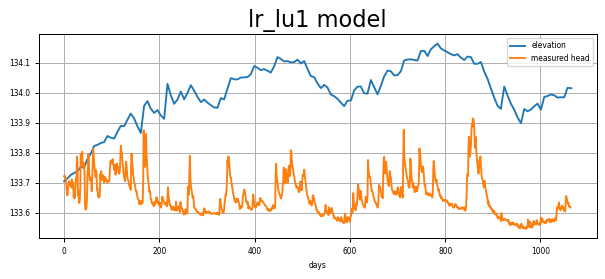

In [178]:
fig = plt.figure(figsize=(8, 3), dpi=90)
ax = fig.add_subplot(1, 1, 1)
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('lr_lu1 model', fontsize=18)

results.plot('days','elevation', ax=ax)
plt.plot([i for i in range(len(head))], head.value.values, label='measured head')
plt.grid()
plt.legend()
plt.show()

### Parameterize model

In [21]:
def write_script(filename, lines):
    '''
    Function for writing scripts (e.g. PLPROC, OLPROC, TPL2PST, e.t.c.)
    '''
    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [22]:
os.listdir(ws)

['evapot.dat',
 'lr_calib_tmp.csv',
 'lr_calib_tmp.in',
 'lr_calib_tmp.out',
 'lr_calib_tmp.tpl',
 'lumprem_variables.rec',
 'obs-head-lrcalib.ssf',
 'rainfall.dat']

In [36]:
with open(os.path.join(ws, 'lr_calib_tmp.tpl'), 'r') as f:
    lines = f.readlines()

In [37]:
lines[2] = '$mvol$   0.0   \n'
lines[4] = '$ks$   $m$   0.5   0.1   \n'
lines[6] = '$offset$   $f1$   $f2$   $pow$   -9999.0   10000.0\n' # '$offset$ $f1$  $f2$  $p$  -9999.0 10000.0\n'
lines[10] = '$vol$\n'
lines[35] = '$crfac$   $gamma$\n'

In [38]:
with open(os.path.join(ws, 'lr_calib_tmp.tpl'), 'w') as f:
    for line in lines:
        f.write(line)

In [27]:
write_script(os.path.join(ws, 'tpl2pst.in'), [
f'''
# Kh pilot points
start template_file
  template_file     = lr_calib_tmp.tpl
  model_input_file  = lr_calib_tmp.in
  transform         = log
  value             = 1.0
  lower_bound       = 0.1
  upper_bound       = 10.0
  pargroup          = changethis
end template_file
'''
])

In [39]:
p = subprocess.run(['tpl2pst', 'tpl2pst.in', 'param.pst'], cwd=ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 TPL2PST Version 17.3. Watermark Numerical Computing.
 - file tpl2pst.in read ok.

 - reading file lr_calib_tmp.tpl...
 - 10 params found in file lr_calib_tmp.tpl.

 - writing file param.pst...
 - file param.pst written ok.



In [40]:
with open(os.path.join(ws, 'param.pst'), 'r') as f:
    pstfile = f.readlines()

pardata_strt = pstfile.index('* parameter data\n') + 1
pardata_stop = pstfile.index('* observation groups\n')

In [41]:
# Parameters
pardata_df = pd.DataFrame(
    [i.split() for i in pstfile[pardata_strt:pardata_stop]],
    columns=['PARNME', 'PARTRANS', 'PARCHGLIM', 'PARVAL1', 'PARLBND', 'PARUBND', 'PARGP', 'SCALE', 'OFFSET']
)
pardata_df.PARGP = pardata_df.PARNME
pardata_df

,PARNME,PARTRANS,PARCHGLIM,PARVAL1,PARLBND,PARUBND,PARGP,SCALE,OFFSET
0,mvol,log,factor,1.000000,0.1000000,10.00000,mvol,1.0,0.0
1,ks,log,factor,1.000000,0.1000000,10.00000,ks,1.0,0.0
2,m,log,factor,1.000000,0.1000000,10.00000,m,1.0,0.0
3,offset,log,factor,1.000000,0.1000000,10.00000,offset,1.0,0.0
4,f1,log,factor,1.000000,0.1000000,10.00000,f1,1.0,0.0
5,f2,log,factor,1.000000,0.1000000,10.00000,f2,1.0,0.0
6,p,log,factor,1.000000,0.1000000,10.00000,p,1.0,0.0
7,vol,log,factor,1.000000,0.1000000,10.00000,vol,1.0,0.0
8,crfac,log,factor,1.000000,0.1000000,10.00000,crfac,1.0,0.0
9,gamma,log,factor,1.000000,0.1000000,10.00000,gamma,1.0,0.0


In [42]:
pardata_df.loc[pardata_df.PARNME == 'mvol', 'PARVAL1'] = 1.0
pardata_df.loc[pardata_df.PARNME == 'mvol', 'PARLBND'] = 0.5
pardata_df.loc[pardata_df.PARNME == 'mvol', 'PARUBND'] = 1.5

pardata_df.loc[pardata_df.PARNME == 'ks', 'PARVAL1'] = 153.0
pardata_df.loc[pardata_df.PARNME == 'ks', 'PARLBND'] = 0.001
pardata_df.loc[pardata_df.PARNME == 'ks', 'PARUBND'] = 1000

pardata_df.loc[pardata_df.PARNME == 'm', 'PARVAL1'] = 0.17
pardata_df.loc[pardata_df.PARNME == 'm', 'PARLBND'] = 0.01
pardata_df.loc[pardata_df.PARNME == 'm', 'PARUBND'] = 2.0

pardata_df.loc[pardata_df.PARNME == 'offset', 'PARVAL1'] = 3.1
pardata_df.loc[pardata_df.PARNME == 'offset', 'PARLBND'] = 0.1
pardata_df.loc[pardata_df.PARNME == 'offset', 'PARUBND'] = 6.0
pardata_df.loc[pardata_df.PARNME == 'offset', 'OFFSET'] = 130.0

pardata_df.loc[pardata_df.PARNME == 'f1', 'PARVAL1'] = 1.06
pardata_df.loc[pardata_df.PARNME == 'f1', 'PARLBND'] = 0.1
pardata_df.loc[pardata_df.PARNME == 'f1', 'PARUBND'] = 50.0

pardata_df.loc[pardata_df.PARNME == 'f2', 'PARVAL1'] = 0.83
pardata_df.loc[pardata_df.PARNME == 'f2', 'PARLBND'] = 0.01
pardata_df.loc[pardata_df.PARNME == 'f2', 'PARUBND'] = 100.0

pardata_df.loc[pardata_df.PARNME == 'pow', 'PARVAL1'] = 0.72
pardata_df.loc[pardata_df.PARNME == 'pow', 'PARLBND'] = 0.01
pardata_df.loc[pardata_df.PARNME == 'pow', 'PARUBND'] = 100.0

pardata_df.loc[pardata_df.PARNME == 'vol', 'PARVAL1'] = 0.268
pardata_df.loc[pardata_df.PARNME == 'vol', 'PARLBND'] = 0.01
pardata_df.loc[pardata_df.PARNME == 'vol', 'PARUBND'] = 0.5

pardata_df.loc[pardata_df.PARNME == 'crfac', 'PARVAL1'] = 2.207
pardata_df.loc[pardata_df.PARNME == 'crfac', 'PARLBND'] = 0.01
pardata_df.loc[pardata_df.PARNME == 'crfac', 'PARUBND'] = 10.0

pardata_df.loc[pardata_df.PARNME == 'gamma', 'PARVAL1'] = 2.07
pardata_df.loc[pardata_df.PARNME == 'gamma', 'PARLBND'] = 0.01
pardata_df.loc[pardata_df.PARNME == 'gamma', 'PARUBND'] = 100.0

In [43]:
pardata_df

,PARNME,PARTRANS,PARCHGLIM,PARVAL1,PARLBND,PARUBND,PARGP,SCALE,OFFSET
0,mvol,log,factor,1,0.5,1.5,mvol,1.0,0.0
1,ks,log,factor,153,0.001,1000,ks,1.0,0.0
2,m,log,factor,0.17,0.01,2,m,1.0,0.0
3,offset,log,factor,3.1,0.1,6,offset,1.0,130
4,f1,log,factor,1.06,0.1,50,f1,1.0,0.0
5,f2,log,factor,0.83,0.01,100,f2,1.0,0.0
6,p,log,factor,1.000000,0.1000000,10.00000,p,1.0,0.0
7,vol,log,factor,0.268,0.01,0.5,vol,1.0,0.0
8,crfac,log,factor,2.207,0.01,10,crfac,1.0,0.0
9,gamma,log,factor,2.07,0.01,100,gamma,1.0,0.0


In [44]:
pardata_df.sort_values(['PARGP', 'PARNME'], inplace=True)

In [45]:
pardata_list = pardata_df.values.tolist()
pardata_new = []
for i in pardata_list:
    pardata_new.append(' '.join(str(v) for v in i))
pardata_new = [i + '\n' for i in pardata_new]
pstfile_temp = pstfile[:]
for (index, replacement) in zip([i for i in range(pardata_strt, pardata_stop)], pardata_new):
    pstfile_temp[index] = replacement

In [46]:
# Parameter groups
pargrp_start = pstfile_temp.index('* parameter groups\n') + 1
pargrp_stop = pstfile_temp.index('* parameter data\n')
pargrp_df = pd.DataFrame(pstfile_temp[pargrp_start:pargrp_stop])
pargrp_df.iloc[:,0] = pargrp_df.iloc[:,0].str.replace(r'\ (?= *?\ )', '')
pargrp_cols = ['PARGPNME', 'INCTYP', 'DERINC', 'DERINCLB', 'FORCEN', 'DERINCMUL', 'DERMTHD']
pargrp_df[pargrp_cols] = pargrp_df[0].str.split(' ', 7, expand=True)
pargrp_df = pargrp_df[pargrp_cols]
display(pargrp_df)
pargrp_new = [' '.join(str(v) for v in [i, 'relative', 0.015, 0.0, 'switch', 2, 'parabolic\n']) for i in pardata_df['PARGP'].unique()]
display(pargrp_new)

,PARGPNME,INCTYP,DERINC,DERINCLB,FORCEN,DERINCMUL,DERMTHD
0,changethis,relative,0.015,0.0,switch,2,parabolic\n


['crfac relative 0.015 0.0 switch 2 parabolic\n',
 'f1 relative 0.015 0.0 switch 2 parabolic\n',
 'f2 relative 0.015 0.0 switch 2 parabolic\n',
 'gamma relative 0.015 0.0 switch 2 parabolic\n',
 'ks relative 0.015 0.0 switch 2 parabolic\n',
 'm relative 0.015 0.0 switch 2 parabolic\n',
 'mvol relative 0.015 0.0 switch 2 parabolic\n',
 'offset relative 0.015 0.0 switch 2 parabolic\n',
 'p relative 0.015 0.0 switch 2 parabolic\n',
 'vol relative 0.015 0.0 switch 2 parabolic\n']

In [47]:
pstfile_new = pstfile_temp[:]
pstfile_new[pargrp_start:pargrp_stop] = pargrp_new

In [48]:
pstfile_new # Delete row

['pcf\n',
 '* control data\n',
 'restart estimation\n',
 '        10         0         1         0         0\n',
 '    1  0    single  point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 ' 50  0.005  4  4  0.005  4\n',
 ' 0  0  0\n',
 '* singular value decomposition\n',
 '1\n',
 '  5000  5e-7\n',
 '0\n',
 '* parameter groups\n',
 'crfac relative 0.015 0.0 switch 2 parabolic\n',
 'f1 relative 0.015 0.0 switch 2 parabolic\n',
 'f2 relative 0.015 0.0 switch 2 parabolic\n',
 'gamma relative 0.015 0.0 switch 2 parabolic\n',
 'ks relative 0.015 0.0 switch 2 parabolic\n',
 'm relative 0.015 0.0 switch 2 parabolic\n',
 'mvol relative 0.015 0.0 switch 2 parabolic\n',
 'offset relative 0.015 0.0 switch 2 parabolic\n',
 'p relative 0.015 0.0 switch 2 parabolic\n',
 'vol relative 0.015 0.0 switch 2 parabolic\n',
 '* parameter data\n',
 'crfac log factor 2.207 0.01 10.0 crfac 1.0 0.0\n',
 'f1 log factor 1.06 0.1 50.0 f1 1.0 0.0\n',
 'f2 log factor 0.83 0.01 1

In [49]:
# Change npar
temp_row = pstfile_new[3].split()
npargp = len(pardata_df['PARGP'].unique()) # number of parameter groups
temp_row[2] = str(npargp)
temp_row[-1] = '0\n'
new_row = ' '.join(temp_row)
pstfile_new[3] = new_row

In [50]:
# Write partial pestfile
with open(os.path.join(ws, 'calib0.pst'), 'w') as f:
    for line in pstfile_new:
        f.write(line)

In [51]:
p = subprocess.run(['i64pestchek', 'calib0.pst'], cwd=ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)

 PESTCHEK Version 17.3. Watermark Numerical Computing.

 Errors ----->
 Line 4 of file calib0.pst: integer variable NOBS given as zero.
   (Give all observations zero weight to optimize using prior info only.)
 Line 4 of file calib0.pst: integer variable NOBSGP zero or negative.
 Line 5 of file calib0.pst: integer variable NINSFLE zero or negative.



In [52]:
# Write script to postprocess lr results:
write_script(os.path.join(ws, 'lr_results_curation.py'), [
'''
import pandas as pd

print('Curating LR results for OLPROC.')

result = pd.read_csv('lr_calib_tmp.csv')
result = result[['days', 'elevation']]
result.rename(columns={'days': 'time', 'elevation': 'ni15-o48'}, inplace=True)
result.to_csv('lr_results.csv', index=False)
        
print('Curation of LR results completed.')
'''
])

In [53]:
obs_ssf_folder = os.path.join(ws, 'obs_files')
if os.path.exists(obs_ssf_folder):
    shutil.rmtree(obs_ssf_folder)
    os.mkdir(obs_ssf_folder)
else:
    os.mkdir(obs_ssf_folder)

In [54]:
p = subprocess.run(['python', 'lr_results_curation.py'], cwd=ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)

Curating LR results for OLPROC.
Curation of LR results completed.



In [55]:
# write olproc script:
write_script(os.path.join(ws, 'olproc.in'), [
'''
START GENERAL
  date_format        = dd/mm/yyyy

  # the 1st timestep is a 1-day steady state stress period
  # the subsequent transient stress period starts on 01/01/2016 
  model_start_date   = 10/12/2015
  model_start_time   = 00:00:00
  
  # MODFLOW6 time-step units are setup as day.
  model_time_units   = days

  # Set the History Matching Window
  history_match_start_date  = 10/12/2015
END GENERAL

START MEAS_SSF_FILES
  # Read the head measurements for layers 1, 2 and 3
  file = obs-head-lrcalib.ssf      group=heads   use_abs=yes  use_diff=yes
END MEAS_SSF_FILES

START MF6_OBS_FILES
  file = lr_results.csv
END MF6_OBS_FILES

START OUTPUT
  partial_pest_control_file = partial1.pst
  model_batch_file          = runmodel.bat
  obs_ssf_folder            = .\obs_files
END OUTPUT
'''
])

In [56]:
p = subprocess.run(['olproc', 'olproc.in', '0'], cwd=ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 OLPROC Version 1.0. Watermark Numerical Computing.

 - file olproc.in read ok.
 - file lr_results.csv read ok.
 - file obs-head-lrcalib.ssf read ok.
 - file .\obs_files\o_obs-head-lrcalib_ssf.ssf written ok.
 - file m_obs-head-lrcalib_ssf.ins written ok.
 - file m_obs-head-lrcalib_ssf.ssf written ok.
 - file .\obs_files\o_obs-head-lrcalib_ssf_d.ssf written ok.
 - file m_obs-head-lrcalib_ssf_d.ins written ok.
 - file m_obs-head-lrcalib_ssf_d.ssf written ok.
 - file partial1.pst written ok.
 
   Number of observations [NOBS]         = 2125
   Number of observation groups [NOBSGP] = 2
   Number of instruction files [NINSFLE] = 2



In [ ]:
# Manually cut and paste partial1 and calib0 together. Name this file calib1.

In [57]:
p = subprocess.run(['i64pestchek', 'calib1.pst'], cwd=ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)

 PESTCHEK Version 17.3. Watermark Numerical Computing.

 Errors ----->
 No errors encountered.

 Warnings ----->
 NOPTMAX provided as zero. No optimisation iterations will be carried out; 
   objective function and residuals will be recorded for initial parameter 
   estimates only.
 MAXSING in the singular value decomposition section is greater than the 
   number of adjustable parameters.



In [58]:
### Write runmodel script:
write_script(os.path.join(ws, 'runmodel.bat'), [
'''
@echo off
Rem ###################################
Rem Some intermediate files are deleted as a precaution.
Rem Delete computed output
Rem ###################################
del /s *.csv
del /s *.out

Rem ###################################
Rem Run LUMPREM model
Rem ###################################
lumprem2 lr_calib_tmp.in lr_calib_tmp.out lr_calib_tmp.csv

Rem ###################################
Rem Run Python LR curation script
Rem ###################################
python lr_results_curation.py

Rem ###################################
Rem Postprocess observations
Rem ###################################
olproc olproc.in 1
'''
])

In [59]:
# Run model manually

In [60]:
p = subprocess.run(['pwtadj1', 'calib1.pst', 'calib1-wt.pst', '1000'], cwd=ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 PWTADJ1 version 17.3. Watermark Numerical Computing.

 - reading PEST control file calib1.pst for first time...
 - file calib1.pst read ok.

 - reading PEST run record file calib1.rec...
 - file calib1.rec read ok.

 - re-reading file calib1.pst and writing file calib1-wt.pst...
 - file calib1.pst read ok.
 - file calib1-wt.pst written ok.



In [61]:
# Run calib1-wt.pst manually after changing noptmax to 0

In [62]:
# Add regularization

In [63]:
p = subprocess.run(['addreg1', 'calib1-wt.pst', 'calib1-wt-reg.pst'], cwd=ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 ADDREG1 version 17.3. Watermark Numerical Computing.
 - file calib1-wt.pst read ok.
 - file calib1-wt-reg.pst written ok.



In [65]:
# Run calibration

In [72]:
# Use parrep to transfer optimal parameter values after calibration
p = subprocess.run([
    'parrep',
    'calib1-wt-reg.par', # CHANGE THIS
    'calib1-wt-reg.pst',
    'calib-parrep.pst',
    '0'
], cwd=ws, stdout=subprocess.PIPE, text=True)

for row in p.stdout.split('\n'):
    print(row)


PARREP Version 17.3. Watermark Numerical Computing.

Reading parameter value file calib1-wt-reg.par ----->
Data for 10 parameters read from file calib1-wt-reg.par.

Reading file calib1-wt-reg.pst and writing file calib-parrep.pst ----->
File calib-parrep.pst written ok.



In [73]:
# Run calib-parrep.pst once

In [74]:
# import and inspect calibrated results
lr_res = pd.read_csv(os.path.join(ws, 'lr_results.csv'))

In [75]:
sp_start = pd.to_datetime('2015-12-10') + pd.to_timedelta(lr_res.time.values,unit='d')
lr_res['datetime'] = sp_start
#lr_res.drop('time', axis=1, inplace=True)
lr_res.head()

,time,ni15-o48,datetime
0,0,133.7250,2015-12-10
1,7,133.7167,2015-12-17
2,14,133.7118,2015-12-24
3,21,133.7034,2015-12-31
4,28,133.6968,2016-01-07


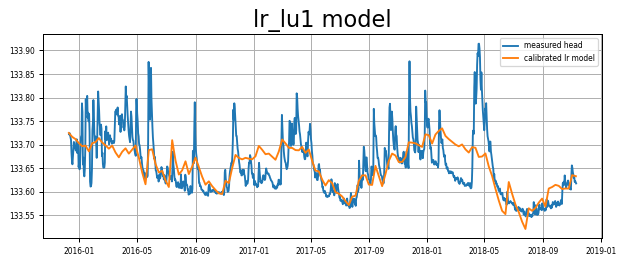

In [76]:
fig = plt.figure(figsize=(8, 3), dpi=90)
ax = fig.add_subplot(1, 1, 1)
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('lr_lu1 model', fontsize=18)


plt.plot(head.datetime.values, head.value.values, label='measured head')
plt.plot(lr_res.datetime.values, lr_res['ni15-o48'], label='calibrated lr model')
plt.grid()
plt.legend()
plt.show()

In [77]:
# Residuals
rei_df = pd.read_csv(os.path.join(ws, 'calib-parrep.rei'), skiprows=6, delim_whitespace=True)
rei_df.columns = rei_df.columns.str.lower()
rei_df['sites'] = [i.split('_')[0] for i in rei_df.name]
rei = rei_df.loc[(rei_df['sites'] == 'ni15-o48') & (rei_df['group'] == 'heads')]

In [78]:
rei['datetime'] = head.datetime[:-1]

<ipython-input-78-d1245e90cf3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rei['datetime'] = head.datetime[:-1]


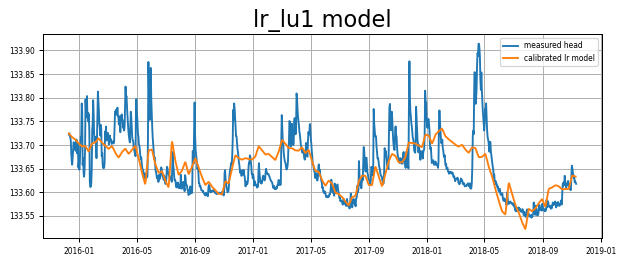

In [79]:
fig = plt.figure(figsize=(8, 3), dpi=90)
ax = fig.add_subplot(1, 1, 1)
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('lr_lu1 model', fontsize=18)


plt.plot(head.datetime.values, head.value.values, label='measured head')
plt.plot(rei.datetime.values, rei.modelled.values, label='calibrated lr model')
plt.grid()
plt.legend()
plt.show()